In [7]:
import pandas as pd
import numpy as np
import recmetrics
import matplotlib.pyplot as plt
from surprise import Reader, SVD, Dataset
from surprise.model_selection import train_test_split

# MovieLense Dataset
Using the MovieLens 20M Dataset dataset for examples. You can download this data here: https://grouplens.org/datasets/movielens/20m/

In [8]:
ratings = pd.read_csv('../movie_similarity_flask_api/data/ml-20m/ratings.csv')
ratings = ratings.query('rating >=3')
ratings.reset_index(drop=True, inplace=True)

In [9]:
#only consider ratings from users who have rated over n movies
n=1000
users = ratings.userId.value_counts()
users = users[users>n].index.tolist()

In [10]:
ratings = ratings.query('userId in @users')
print ratings.shape
ratings.head(3)

(1317902, 4)


,userId,movieId,rating,timestamp
15918,156,1,5.0,1037739266
15919,156,2,5.0,1040937649
15920,156,4,3.0,1038801803


In [11]:
# get movie features

rated_movies = ratings.movieId.tolist()
movies = pd.read_csv('../movie_similarity_flask_api/data/ml-20m/movies.csv')
movies = movies.query('movieId in @rated_movies')
movies.set_index("movieId", inplace=True, drop=True)

movies = movies.genres.str.split("|", expand=True)
movies.reset_index(inplace=True)
movies = pd.melt(movies, id_vars='movieId', value_vars=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

movies.drop_duplicates("movieId", inplace=True)
movies.set_index('movieId', inplace=True)

movies = pd.get_dummies(movies.value)
#movies = movies[['Action', 'Romance', 'Western', 'Comedy', 'Crime']]
movies.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Long Tail Plot Example

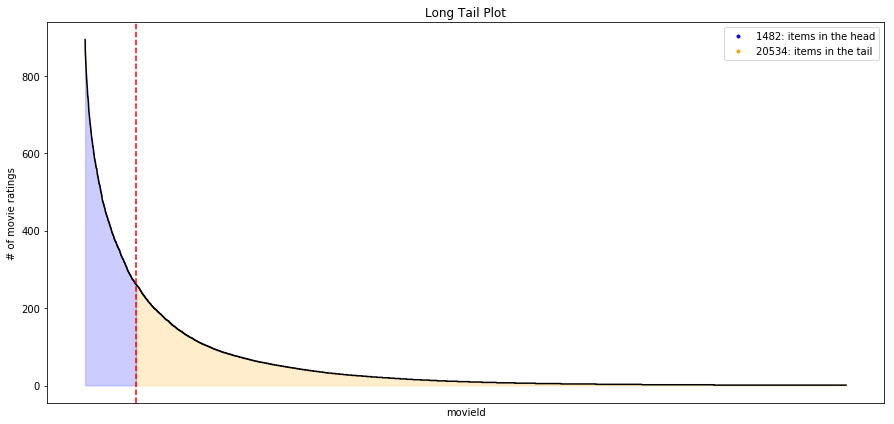

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 7))
recmetrics.LongTailPlot(df=ratings, 
             item_id_column="movieId", 
             interaction_type="movie ratings", 
             percentage=0.5,
             x_labels=False)

# Collaborative Filter Recommender
Creating a simple CF to demonstrate recommender metrics in action. I've implemented collaborative filtering using a SVD approach in the surprise package. The surprise package also takes care of the test train split. The collaborative filter transforms user-item interactions into latent space, and reconstructs the user-item matrix to impute ratings missing movie ratings. The predicted rating is the dot product between the user and movie vectors in latent space. 

In [13]:
#format data for surprise
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)

In [14]:
#train SVD recommender 
algo = SVD()
algo.fit(trainset)

In [15]:
#make predictions on test set. 
test = algo.test(testset)
test = pd.DataFrame(test)
test.drop("details", inplace=True, axis=1)
test.columns = ['userId', 'movieId', 'actual', 'cf_predictions']
test.head()

,userId,movieId,actual,cf_predictions
0,131904,96811,3.0,3.529538
1,65919,523,4.0,3.564024
2,117054,3441,3.0,3.474852
3,51995,49272,3.5,4.392490
4,982,3635,3.0,3.238261


In [16]:
#evaluate model with MSE and RMSE
print recmetrics.mse(test.actual, test.cf_predictions)
print recmetrics.rmse(test.actual, test.cf_predictions)

0.26675325067103167
0.516481607292


In [17]:
#create model (matrix of predicted values)
cf_model = test.pivot_table(index='userId', columns='movieId', values='cf_predictions').fillna(0)

In [18]:
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [19]:
#get example prediction
get_users_predictions(156, 10, cf_model)

[2028, 1291, 589, 457, 47, 1954, 858, 4886, 2918, 2716]

In [20]:
#format test data
test = test.copy().groupby('userId')['movieId'].agg({'actual': (lambda x: list(set(x)))})
#make recommendations for all members in the test data
recs = []
for user in test.index:
    cf_predictions = get_users_predictions(user, 10, cf_model)
    recs.append(cf_predictions)
        
test['cf_predictions'] = recs
test.head()

/Users/clairelongo/Documents/Work/prof_dev/recmetrics/venv/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,actual,cf_predictions
userId,,
156,"[4, 5, 4102, 2058, 2067, 20, 4117, 2071, 2073,...","[2028, 1291, 589, 457, 47, 1954, 858, 4886, 29..."
208,"[3072, 1537, 89090, 83976, 2732, 11, 81932, 93...","[2019, 6896, 527, 1178, 3089, 1230, 1193, 1256..."
359,"[1537, 33794, 5635, 37382, 1544, 3081, 1546, 2...","[593, 2571, 1148, 7153, 899, 1200, 2028, 5782,..."
394,"[1537, 2987, 1028, 6230, 2054, 3461, 1546, 103...","[923, 858, 1217, 1260, 908, 1267, 26131, 1213,..."
572,"[2561, 69122, 4011, 48520, 5125, 2054, 69640, ...","[50, 3147, 4226, 64614, 1193, 99114, 68157, 49..."


# Popularity Recommender
Creating a simple popularity recommender to demonstrate recommender metrics in action. The popularity recommender simply recommends the top 10 movies to every user.

In [21]:
#make recommendations for all members in the test data
popularity_recs = ratings.movieId.value_counts().head(10).index.tolist()

recs = []
for user in test.index:
    pop_predictions = popularity_recs
    recs.append(pop_predictions)
        
test['pop_predictions'] = recs
test.head()

,actual,cf_predictions,pop_predictions
userId,,,
156,"[4, 5, 4102, 2058, 2067, 20, 4117, 2071, 2073,...","[2028, 1291, 589, 457, 47, 1954, 858, 4886, 29...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
208,"[3072, 1537, 89090, 83976, 2732, 11, 81932, 93...","[2019, 6896, 527, 1178, 3089, 1230, 1193, 1256...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
359,"[1537, 33794, 5635, 37382, 1544, 3081, 1546, 2...","[593, 2571, 1148, 7153, 899, 1200, 2028, 5782,...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
394,"[1537, 2987, 1028, 6230, 2054, 3461, 1546, 103...","[923, 858, 1217, 1260, 908, 1267, 26131, 1213,...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
572,"[2561, 69122, 4011, 48520, 5125, 2054, 69640, ...","[50, 3147, 4226, 64614, 1193, 99114, 68157, 49...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."


# Random Recommender
Creating a simple random recommender to demonstrate recommender metrics in action. The random recommender simply recommends 10 random movies to every user.

In [22]:
#make recommendations for all members in the test data

recs = []
for user in test.index:
    random_predictions = ratings.movieId.sample(10).values.tolist()
    recs.append(random_predictions)
        
test['random_predictions'] = recs
test.head()

,actual,cf_predictions,pop_predictions,random_predictions
userId,,,,
156,"[4, 5, 4102, 2058, 2067, 20, 4117, 2071, 2073,...","[2028, 1291, 589, 457, 47, 1954, 858, 4886, 29...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[25769, 55553, 4040, 8961, 1252, 5963, 4496, 5..."
208,"[3072, 1537, 89090, 83976, 2732, 11, 81932, 93...","[2019, 6896, 527, 1178, 3089, 1230, 1193, 1256...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[4784, 72407, 53468, 27773, 5036, 553, 1147, 6..."
359,"[1537, 33794, 5635, 37382, 1544, 3081, 1546, 2...","[593, 2571, 1148, 7153, 899, 1200, 2028, 5782,...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[2671, 914, 4885, 3394, 747, 553, 41566, 3469,..."
394,"[1537, 2987, 1028, 6230, 2054, 3461, 1546, 103...","[923, 858, 1217, 1260, 908, 1267, 26131, 1213,...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[33679, 3997, 1299, 56171, 116397, 2533, 2321,..."
572,"[2561, 69122, 4011, 48520, 5125, 2054, 69640, ...","[50, 3147, 4226, 64614, 1193, 99114, 68157, 49...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[38061, 434, 2991, 3448, 3510, 3981, 4128, 250..."


# Recall

In [23]:
actual = test.actual.values.tolist()
cf_predictions = test.cf_predictions.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()
random_predictions = test.random_predictions.values.tolist()

In [24]:
pop_mark = []
for K in np.arange(1, 11):
    pop_mark.extend([recmetrics.mark(actual, pop_predictions, k=K)])
pop_mark

[0.0007115043261448315,
 0.0011813196632255113,
 0.0015596245566349804,
 0.0018971549724899775,
 0.0021888767608767485,
 0.002431404800389665,
 0.0026661641285071406,
 0.002911371762311861,
 0.0031362016163547207,
 0.0033645291292464887]

In [25]:
random_mark = []
for K in np.arange(1, 11):
    random_mark.extend([recmetrics.mark(actual, random_predictions, k=K)])
random_mark

[0.00026834903548434466,
 0.00039590676001214335,
 0.0004912922671089597,
 0.0005711520923453073,
 0.0006429117744289767,
 0.000688511958634699,
 0.0007438254860839299,
 0.0007927883963338959,
 0.0008381165667668639,
 0.0008707169372023664]

In [26]:
cf_mark = []
for K in np.arange(1, 11):
    cf_mark.extend([recmetrics.mark(actual, cf_predictions, k=K)])
cf_mark

[0.003075930658968026,
 0.006151861317936052,
 0.009227791976904078,
 0.012303722635872105,
 0.015379653294840128,
 0.018455583953808155,
 0.021531514612776175,
 0.02460744527174421,
 0.027683375930712233,
 0.030759306589680256]

# Mark Plot

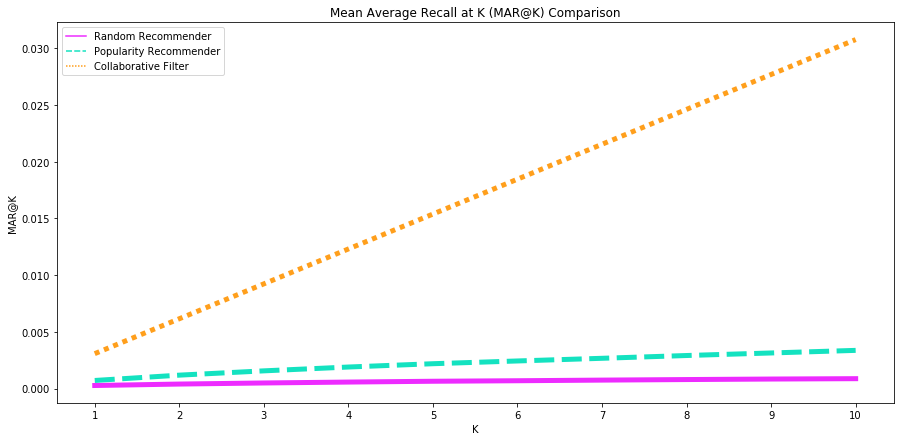

In [27]:
mark_scores = [random_mark, pop_mark, cf_mark]
index = range(1,10+1)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(15, 7))
recmetrics.MarkPlot(mark_scores, model_names=names, k_range=index)

# Coverage

In [28]:
catalog = ratings.movieId.unique().tolist()
random_coverage = recmetrics.coverage(random_predictions, catalog)
pop_coverage = recmetrics.coverage(pop_predictions, catalog)
cf_coverage = recmetrics.coverage(cf_predictions, catalog)

# Coverage Plot

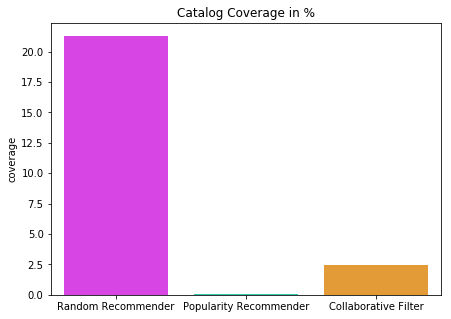

In [29]:
coverage_scores = [random_coverage, pop_coverage, cf_coverage]
model_names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(7, 5))
recmetrics.CoveragePlot(coverage_scores, model_names)

# Personalization

In [30]:
example_predictions = [
    ['1', '2', 'C', 'D'],
    ['4', '3', 'm', 'X'],
    ['7', 'B', 't', 'X']
]

In [31]:
recmetrics.personalization(predicted=example_predictions)

0.9166666666666666

# Intra-list Similarity

In [32]:
example_predictions = [
    [3, 7, 5, 9],
    [9, 6, 12, 623],
    [7, 894, 6, 623]
]

In [33]:
feature_df = movies[['Action', 'Comedy', 'Romance']]

In [34]:
recmetrics.intra_list_similarity(example_predictions, feature_df)

0.27777777777777773

# Classification Probability Plot

In [35]:
#make fake classification probability data
class_one_probs = np.random.normal(loc=.7, scale=0.1, size=1000)
class_zero_probs = np.random.normal(loc=.3, scale=0.1, size=1000)
actual = [1] * 1000
class_zero_actual = [0] * 1000
actual.extend(class_zero_actual)

pred_df = pd.DataFrame([np.concatenate((class_one_probs, class_zero_probs), axis=None), actual]).T
pred_df.columns = ["probability", "truth"]
pred_df.head()

,probability,truth
0,0.770020,1.0
1,0.739513,1.0
2,0.697432,1.0
3,0.651279,1.0
4,0.851955,1.0


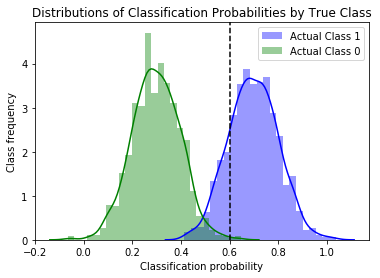

In [36]:
recmetrics.ClassDistributionPlot(pred_df, .6)